# Rain in Australia
## Classification Problem with Logistic Regression in Scikit Learn

Our task is predict predict next-day rain by training classification models.

[This dataset](https://kaggle.com/jsphyg/weather-dataset-rattle-package) comprises about 10 years of daily weather observations from numerous locations across Australia.

RainTomorrow is the target variable to predict. It answers the crucial question: will it rain the next day? (Yes or No).

### Imports

In [1]:
import opendatasets as od
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, roc_curve, auc

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

pd.set_option('display.max_columns', None)

### Load data

In [3]:
dataset_url = 'https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package'

temp_dir = '../temp'
data_dir = '../data'

od.download(dataset_url, temp_dir)

for root, dirs, files in os.walk(temp_dir):
    if files:
        dataset_path = root

for file in os.listdir(dataset_path):
    src = os.path.join(dataset_path, file)
    dst = os.path.join(data_dir, file)
    shutil.move(src, dst)

shutil.rmtree(temp_dir)

print("Dataset moved successfully to:", data_dir)

Dataset URL: https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package


100%|██████████████████████████████████████████████████████████████████████████████| 3.83M/3.83M [00:00<00:00, 402MB/s]


Dataset moved successfully to: ../data


In [5]:
os.listdir(data_dir)

['weatherAUS.csv']

In [7]:
train_csv = data_dir + '/weatherAUS.csv'

In [9]:
raw_df = pd.read_csv(train_csv)

In [11]:
raw_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


The dataset contents over 145.000 rows and 23 columns. The dataset contents column with date, numerical and categorical values.

Our goal is to create model for predict values in the column `RainTomorrow`.

In [13]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

While we should be able to fill in missing values for most columns, it may be worth dropping rows where `RainTomorrow` or `RainToday` values are missing since one of them is the target variable and the other is likely very closely related to the target variable.

In [15]:
raw_df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)

In [17]:
raw_df.shape

(140787, 23)

### Train, validation, and test sets

When working with dates, it is often better to separate the training, validation, and test sets by time, so that the model is trained on data from the past and evaluated on data from the future.

For the current dataset, we can use the `Date` column to create another column for the year. 

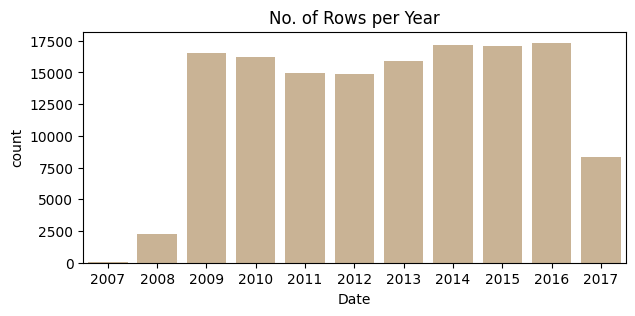

In [23]:
plt.figure(figsize=(7, 3))
plt.title('No. of Rows per Year')
sns.countplot(x=pd.to_datetime(raw_df.Date).dt.year, color='tan');

We will choose the last two years for the test set and the one year before that for the validation set.

In [25]:
year = pd.to_datetime(raw_df.Date).dt.year

train_df = raw_df[year < 2015]
val_df = raw_df[year == 2015]
test_df = raw_df[year > 2015]

In [27]:
print(f"train_df.shape: {train_df.shape}")
print(f"val_df.shape: {val_df.shape}")
print(f"test_df.shape: {test_df.shape}")

train_df.shape: (97988, 23)
val_df.shape: (17089, 23)
test_df.shape: (25710, 23)


While this is not perfect 60-20-20 split, we ensured that the testing and validation datasets contained data from all 12 months of the year.

### Defining input and target columns

In [29]:
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'

In [31]:
print(input_cols)

['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']


And now we can create input data and targets for training, validation, and test sets for further processing and training the model.

In [33]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

In [35]:
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

In [37]:
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

Let's defining which columns are numerical, and which are categorical.

In [39]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

In [41]:
train_inputs[numeric_cols].describe().round(2)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,97674.00,97801.00,97988.00,61657.00,57942.00,91160.00,97114.00,96919.00,96936.00,96872.00,88876.00,88857.00,63000.00,61966.00,97414.00,97392.00
mean,12.01,23.02,2.37,5.29,7.61,40.22,14.09,18.76,68.63,51.47,1017.51,1015.13,4.30,4.41,16.84,21.54
std,6.35,6.98,8.52,3.95,3.79,13.70,8.98,8.87,19.00,20.76,7.07,7.00,2.87,2.69,6.40,6.83
min,-8.50,-4.10,0.00,0.00,0.00,6.00,0.00,0.00,0.00,0.00,980.50,979.00,0.00,0.00,-5.90,-5.10
25%,7.50,17.90,0.00,2.60,4.80,31.00,7.00,13.00,57.00,37.00,1012.80,1010.40,1.00,2.00,12.20,16.60
50%,11.80,22.40,0.00,4.60,8.50,39.00,13.00,19.00,70.00,52.00,1017.50,1015.10,5.00,5.00,16.60,20.90
75%,16.60,27.90,0.80,7.20,10.60,48.00,19.00,24.00,83.00,66.00,1022.30,1019.90,7.00,7.00,21.40,26.20
max,33.90,48.10,371.00,82.40,14.30,135.00,87.00,87.00,100.00,100.00,1041.00,1039.60,9.00,9.00,40.20,46.10


In [43]:
train_inputs[categorical_cols].nunique()

Location       49
WindGustDir    16
WindDir9am     16
WindDir3pm     16
RainToday       2
dtype: int64

### Filling in missing numeric data

In [45]:
imputer = SimpleImputer(strategy='mean')

Before imputation let's check number of missing values for each numeric column.

In [47]:
raw_df[numeric_cols].isna().sum()

MinTemp            468
MaxTemp            307
Rainfall             0
Evaporation      59694
Sunshine         66805
WindGustSpeed     9105
WindSpeed9am      1055
WindSpeed3pm      2531
Humidity9am       1517
Humidity3pm       3501
Pressure9am      13743
Pressure3pm      13769
Cloud9am         52625
Cloud3pm         56094
Temp9am            656
Temp3pm           2624
dtype: int64

In [49]:
train_inputs[numeric_cols].isna().sum() / train_inputs.shape[0] * 100

MinTemp           0.320447
MaxTemp           0.190840
Rainfall          0.000000
Evaporation      37.076989
Sunshine         40.868270
WindGustSpeed     6.968200
WindSpeed9am      0.891946
WindSpeed3pm      1.090950
Humidity9am       1.073601
Humidity3pm       1.138915
Pressure9am       9.299098
Pressure3pm       9.318488
Cloud9am         35.706413
Cloud3pm         36.761644
Temp9am           0.585786
Temp3pm           0.608238
dtype: float64

There are a lot of missing values in `Sunshine` and `Evaporation` columns, but this information could be very useful for model, so let's try to fill them.

In [51]:
imputer.fit(train_inputs[numeric_cols])

SimpleImputer()

In [53]:
list(imputer.statistics_)

[12.0078311526097,
 23.0222022269711,
 2.37293546148508,
 5.289991404057933,
 7.609003831417626,
 40.21587318999561,
 14.09226270156723,
 18.76460755888938,
 68.62874473879673,
 51.46954744404988,
 1017.5137337413925,
 1015.132351891241,
 4.302952380952381,
 4.410676822773779,
 16.835126367873205,
 21.54013779365862]

In [55]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

In [57]:
train_inputs[numeric_cols].isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

We fill in all missing values in numeric columns with mean values.

### Scaling numeric features

The numeric columns in our dataset have varying ranges.

In [59]:
raw_df[numeric_cols].describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,140319.000000,140480.00000,140787.000000,81093.000000,73982.000000,131682.000000,139732.000000,138256.000000,139270.000000,137286.000000,127044.000000,127018.000000,88162.000000,84693.000000,140131.000000,138163.000000
mean,12.184824,23.23512,2.349974,5.472516,7.630540,39.970520,13.990496,18.631141,68.826833,51.449288,1017.654577,1015.257963,4.431161,4.499250,16.987066,21.693183
std,6.403879,7.11450,8.465173,4.189132,3.781729,13.578201,8.886210,8.798096,19.063650,20.807310,7.104867,7.035411,2.886594,2.719752,6.496012,6.937784
min,-8.500000,-4.80000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000
25%,7.600000,17.90000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1013.000000,1010.400000,1.000000,2.000000,12.300000,16.600000
50%,12.000000,22.60000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000
75%,16.800000,28.30000,0.800000,7.400000,10.700000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000
max,33.900000,48.10000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000


Let's use `MinMaxScaler` for scaling to range (0, 1).

In [61]:
scaler = MinMaxScaler()
scaler.fit(train_inputs[numeric_cols])

MinMaxScaler()

In [63]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

Now we can check if values in each column are in range (0, 1).

In [65]:
train_inputs[numeric_cols].describe().round(2)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00
mean,0.48,0.52,0.01,0.06,0.53,0.27,0.16,0.22,0.69,0.51,0.61,0.60,0.48,0.49,0.49,0.52
std,0.15,0.13,0.02,0.04,0.20,0.10,0.10,0.10,0.19,0.21,0.11,0.11,0.26,0.24,0.14,0.13
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.38,0.42,0.00,0.05,0.52,0.19,0.08,0.15,0.57,0.37,0.54,0.53,0.33,0.33,0.39,0.42
50%,0.48,0.51,0.00,0.06,0.53,0.26,0.15,0.22,0.69,0.52,0.61,0.60,0.48,0.49,0.49,0.51
75%,0.59,0.61,0.00,0.07,0.64,0.31,0.22,0.28,0.83,0.65,0.68,0.67,0.67,0.67,0.59,0.61
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### Encoding categorical features

In [67]:
raw_df[categorical_cols].nunique()

Location       49
WindGustDir    16
WindDir9am     16
WindDir3pm     16
RainToday       2
dtype: int64

In [69]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [71]:
encoder.fit(train_inputs[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [73]:
encoder.categories_

[array(['Adelaide', 'Albany', 'Albury', 'AliceSprings', 'BadgerysCreek',
        'Ballarat', 'Bendigo', 'Brisbane', 'Cairns', 'Canberra', 'Cobar',
        'CoffsHarbour', 'Dartmoor', 'Darwin', 'GoldCoast', 'Hobart',
        'Katherine', 'Launceston', 'Melbourne', 'MelbourneAirport',
        'Mildura', 'Moree', 'MountGambier', 'MountGinini', 'Newcastle',
        'Nhil', 'NorahHead', 'NorfolkIsland', 'Nuriootpa', 'PearceRAAF',
        'Penrith', 'Perth', 'PerthAirport', 'Portland', 'Richmond', 'Sale',
        'SalmonGums', 'Sydney', 'SydneyAirport', 'Townsville',
        'Tuggeranong', 'Uluru', 'WaggaWagga', 'Walpole', 'Watsonia',
        'Williamtown', 'Witchcliffe', 'Wollongong', 'Woomera'],
       dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'W', 'WNW', 'WSW', nan], dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'W', 'WNW', 'WSW', nan], dtype=object),
 ar

In [75]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [77]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

In [79]:
test_inputs

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindGustDir_nan,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir9am_nan,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_No,RainToday_Yes
2498,Albury,0.681604,0.798851,0.000000,0.064199,0.532098,ENE,0.372093,NaN,ESE,0.000000,0.080460,0.46,0.17,0.543802,0.498350,0.777778,0.333333,0.694143,0.816406,No,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2499,Albury,0.693396,0.722222,0.001078,0.064199,0.532098,SSE,0.341085,SSE,SE,0.103448,0.195402,0.54,0.30,0.505785,0.485149,0.888889,0.888889,0.665944,0.718750,No,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2500,Albury,0.634434,0.521073,0.005930,0.064199,0.532098,ENE,0.325581,ESE,ENE,0.126437,0.448276,0.62,0.67,0.553719,0.590759,0.888889,0.888889,0.600868,0.480469,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2501,Albury,0.608491,0.532567,0.042049,0.064199,0.532098,SSE,0.255814,SE,SSE,0.103448,0.195402,0.74,0.65,0.618182,0.618812,0.888889,0.888889,0.544469,0.521484,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

### Training a logistic regression model

In [81]:
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(train_inputs[numeric_cols + encoded_cols], train_targets)

LogisticRegression(random_state=42, solver='liblinear')

In [82]:
print(numeric_cols + encoded_cols)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'Location_Adelaide', 'Location_Albany', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF', 'Location_Penrith', 'Location_Perth', 'Location_PerthAirport', 'Location_Portland', 'Location_Richmond', 'Location_Sale', 'Location_

In [85]:
print(model.coef_.round(4).tolist())

[[0.8943, -2.8543, 3.1629, 0.6409, -1.6499, 6.7644, -0.6515, -1.4202, 0.3242, 5.993, 5.5291, -8.9621, -0.1603, 1.288, 0.4705, 1.9747, 0.6052, -0.5585, 0.4723, -0.0008, 0.3486, -0.3584, 0.1729, 0.4339, -0.0194, 0.0234, 0.2507, -0.0247, -0.035, -0.4886, -0.1333, -0.574, -0.7925, -0.2571, -0.3319, -0.5734, 0.077, 0.004, 0.0612, -0.9084, -0.459, 0.0085, -0.458, -0.4685, -0.0741, 0.1888, 0.4474, 0.6023, 0.4223, -0.0301, 0.2523, -0.3264, 0.4218, -0.0633, -0.1195, -0.7358, 0.3669, 0.1867, 0.1785, 0.1889, -0.2549, 0.011, 0.7062, -0.802, -0.2031, -0.1713, -0.1684, -0.0717, -0.2332, -0.2415, -0.3303, -0.1748, -0.1686, -0.1204, -0.0413, -0.06, -0.1037, -0.1005, -0.2325, -0.268, -0.2104, 0.0765, -0.3292, -0.0401, -0.3381, 0.0194, -0.0314, 0.134, -0.0719, -0.0675, -0.4182, -0.3176, -0.4149, -0.2049, -0.0699, -0.0962, -0.0663, -0.0257, -0.2817, -0.2503, -0.1631, -0.246, 0.028, -0.3222, -0.0904, 0.2744, 0.212, -0.2756, -0.2522, -0.3774, -0.3266, -0.3798, -0.1902, -0.0433, -0.2854, 0.068, -1.5595, -1.

In [87]:
print(model.intercept_)

[-2.6201253]


### Prediction and model evaluation

In [89]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [91]:
X_train.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindGustDir_nan,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir9am_nan,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_No,RainToday_Yes
0,0.516509,0.517241,0.001617,0.064199,0.532098,0.294574,0.229885,0.275862,0.71,0.22,0.449587,0.463696,0.888889,0.490075,0.494577,0.525391,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.375000,0.559387,0.000000,0.064199,0.532098,0.294574,0.045977,0.252874,0.44,0.25,0.497521,0.475248,0.478106,0.490075,0.501085,0.574219,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.504717,0.570881,0.000000,0.064199,0.532098,0.310078,0.218391,0.298851,0.38,0.30,0.447934,0.490099,0.478106,0.222222,0.583514,0.552734,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.417453,0.614943,0.000000,0.064199,0.532098,0.139535,0.126437,0.103448,0.45,0.16,0.613223,0.557756,0.478106,0.490075,0.520607,0.617188,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [93]:
train_preds = model.predict(X_train)

In [95]:
train_preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [97]:
train_targets

0         No
1         No
2         No
3         No
4         No
          ..
144548    No
144549    No
144550    No
144551    No
144552    No
Name: RainTomorrow, Length: 97988, dtype: object

In [99]:
train_probs = model.predict_proba(X_train)
train_probs

array([[0.94462489, 0.05537511],
       [0.94105894, 0.05894106],
       [0.96092428, 0.03907572],
       ...,
       [0.98756249, 0.01243751],
       [0.98341953, 0.01658047],
       [0.87529442, 0.12470558]])

In [101]:
np.argmax(train_probs, axis=1)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

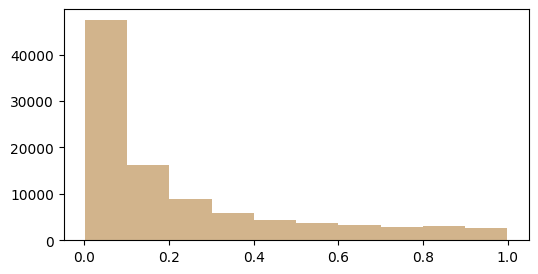

In [107]:
plt.figure(figsize=(6, 3))
plt.hist(train_probs[:, 1], color='tan')
plt.show()

In [109]:
train_targets.value_counts(normalize=True)

No     0.777544
Yes    0.222456
Name: RainTomorrow, dtype: float64

In [111]:
(train_probs[:, 1][:20] > 0.2).astype(int)

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0])

In [113]:
(train_probs[:, 1][:20] > 0.5).astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0])

In [115]:
(train_probs[:, 1][:20] > 0.8).astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0])

In [117]:
model.classes_

array(['No', 'Yes'], dtype=object)

#### Accuracy

In [119]:
accuracy_score(train_targets, train_preds)

0.8520022859942034

The model achieves 85.2% accuracy on the training set. We can visualize the distribution of correctly and incorrectly classified inputs using the confusion matrix.

#### Confusion Matrix

In [121]:
confusion_matrix(train_targets, train_preds, normalize='true')

array([[0.94623966, 0.05376034],
       [0.47738325, 0.52261675]])

Let's define helping function to generate predictions, estimate accuracy and plot confusion matrix for given dataset of input data.

In [123]:
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)

    accuracy = accuracy_score(targets, preds)
    print(f"Accuracy: {(accuracy * 100):.2f}")

    fig, ax = plt.subplots(figsize=(4, 3))
    cm = confusion_matrix(targets, preds, normalize='true')
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(ax=ax, cmap='YlOrBr')
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    return preds

Accuracy: 85.20


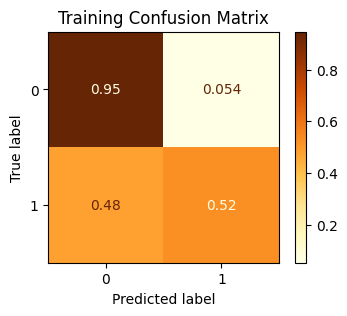

In [125]:
train_preds = predict_and_plot(X_train, train_targets, 'Training')

Let's estimate model on validation and test sets.

Accuracy: 85.39


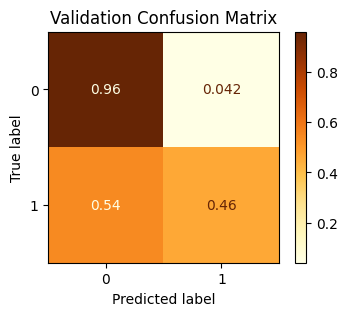

In [127]:
val_preds = predict_and_plot(X_val, val_targets, 'Validation')

Accuracy of our model is approximately 84-85% and true positive prediction (TP) approximately 50% (52 on train, 46 on validation and 48 on test data).

#### F1-score

In [129]:
f1_score(train_targets, train_preds, pos_label='Yes')

0.6110604516440488

In [131]:
def get_f1_score(inputs, targets, name=''):
    preds = model.predict(inputs)

    f1_score_ = f1_score(targets, preds, pos_label='Yes')
    print(f"F1 score on {name}: {f1_score_:.2f}")

In [133]:
get_f1_score(X_train, train_targets, 'Training')
get_f1_score(X_val, val_targets, 'Validation')

F1 score on Training: 0.61
F1 score on Validation: 0.57


#### Building ROC Curve and computing ROC AUC (AUROC)

In [135]:
def compute_auroc_and_building_roc(inputs, targets, name=''):
    # Predict probabilities
    y_pred_proba = model.predict_proba(inputs)[:, 1]

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label='Yes')

    # Compute AUROC
    roc_auc = auc(fpr, tpr)
    print(f"AUROC for {name}: {roc_auc:.2f}")

    # Plot the ROC curve
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, color='chocolate', lw=2,
             label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"Receiver Operating Characteristic (ROC) Curve for {name}")
    plt.legend(loc='lower right')
    plt.show()

AUROC for Training: 0.88


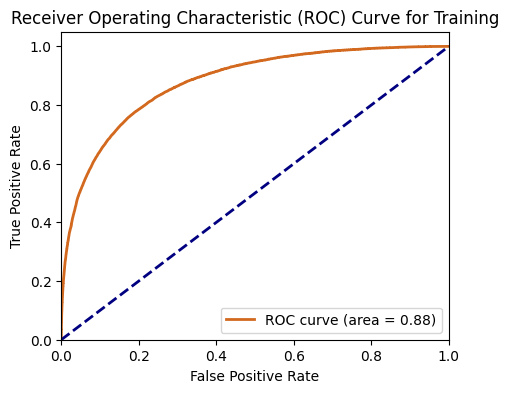

AUROC for Validation: 0.87


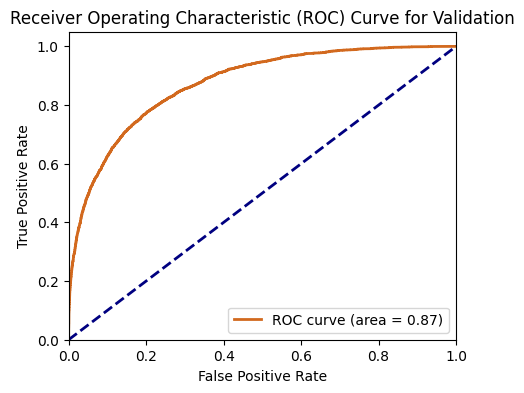

In [137]:
compute_auroc_and_building_roc(X_train, train_targets, 'Training')
compute_auroc_and_building_roc(X_val, val_targets, 'Validation')

### Prediction for one input

Once the model has been training to a satisfactory accuracy, it can be used to predict new data. Consider the following dictionary containing data collected today from the Katherine Meteorological Department.

In [139]:
new_input = {'Date': '2021-06-19',
             'Location': 'Katherine',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

The first step is to convert dictionary into Pandas DataFrame like `raw_df`.

In [141]:
new_input_df = pd.DataFrame([new_input])

In [143]:
new_input_df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,2021-06-19,Katherine,23.2,33.2,10.2,4.2,NaN,NNW,52.0,NW,NNE,13.0,20.0,89.0,58.0,1004.8,1001.5,8.0,5.0,25.7,33.0,Yes


Now we need to apply the same transformations, that were applied when training the model:
1. Imputation of missing values using the previously created `imputer`
2. Scaling of numeric features using the previously created `scaler`
3. Encoding of categorical features using the previously created `encoder`

In [145]:
new_input_df[numeric_cols] = imputer.transform(new_input_df[numeric_cols])
new_input_df[numeric_cols] = scaler.transform(new_input_df[numeric_cols])
new_input_df[encoded_cols] = encoder.transform(new_input_df[categorical_cols])

In [147]:
X_new_input = new_input_df[numeric_cols + encoded_cols]
X_new_input

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindGustDir_nan,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir9am_nan,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_No,RainToday_Yes
0,0.747642,0.714559,0.027493,0.050971,0.532098,0.356589,0.149425,0.229885,0.89,0.58,0.401653,0.371287,0.888889,0.555556,0.685466,0.744141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


And now we can make prediction using `model.predict`

In [151]:
prediction = model.predict(X_new_input)[0]
prediction

'Yes'

Let's check probability of this prediction.

In [153]:
prob = model.predict_proba(X_new_input)[0]
prob

array([0.48102807, 0.51897193])

It's seems that our model no confidence in the prediction of the rain.